In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# Plot the results for visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import time
from scipy import optimize

In [4]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
pls_par = np.array([-580., 10., -10., 20., 30., 15.]) 
mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 

In [5]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)

                         

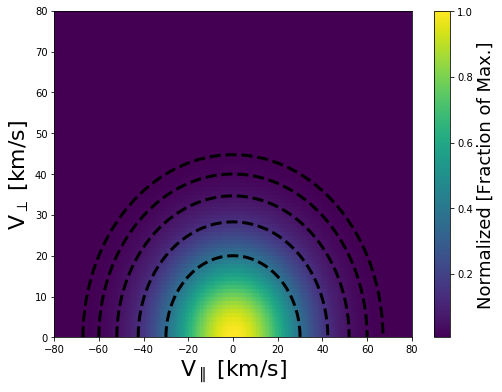

In [6]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

In [7]:
#multi faraday cup solutions
fcs,big_arr = mff.create_multi_fc(dis_vdf,15,v_smp=40)

In [8]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]


#get angles from big_arr
phis   = np.radians(big_arr[:,3])
thetas = np.radians(big_arr[:,4])

#Number of processors to use when parallel processing
nproc = 8


In [9]:
#Use values with density greater than .1 and an uncertainty less than 10% 
top5 = ((un_angl/n_angl < 4.50) & (n_angl > 1e-1)) #np.sort(n_angl)[-6]
print(un_angl/n_angl)


#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(phis[top5],thetas[top5],-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


[  2.80907133e-05   1.44066878e+01   5.77871675e-05   1.03658776e-03
   3.57434425e-05   1.40491378e+01   6.03887144e-04   1.43092996e+01
   2.21795598e-04   8.14378555e-05   7.10681113e-02   3.85173378e-05
   5.88681444e-04   7.59511797e+05   7.63226707e-04]


In [10]:
#Get Wper and Wpar vectors using maximum and minimum values
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.max(w_angl[top5])
we = np.min(w_angl[top5])


In [11]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [12]:
if we < 0.9*np.min(w_angl[top5]):
    we = np.min(w_angl[top5])
elif we > 1.1*np.max(w_angl[top5]):
    we = np.max(w_angl[top5])

if wa < 0.9*np.min(w_angl[top5]):
    wa = np.min(w_angl[top5])
elif wa > 1.1*np.max(w_angl[top5]):
    wa = np.max(w_angl[top5])

#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])


In [13]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-580.   10.  -10.   20.   30.   15.]
[-580.30782269   10.2060952    -5.79773393   22.41170082   30.03082937
   12.74316942]


In [14]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad
dis_vdf_bad = dis_vdf_bad_guess

In [15]:
def gauss_2d_reconstruct(z,fcs,cur_vdf):
    """
    Function that reconstructs the 2D velocity distribution in the V parallel
    and V perp reference frame by assuming a 2D Gaussian.
    
    Parameters
    ------------
    z: list
        A list of input parameters used in the 2D velocity reconstruction. 
        The list must contain the following variables in the following order:
        vx,vy,vz,wper,wpar,den where vx is the x-component of the velocity in
        GSE coordinates, vy in the y-component of the velocity in GSE coordinates
        vz is the z-component of the velocity in GSE coordinates
    fcs: dictionary
        A dictionary of Faraday cups created by mff.create_multi_fc()
    cur_vdf: dictionary
        Dictionary of the velocity distribution created by make_discrete_vdf()
        
    Returns
    -------
    y:float or np.array
        The measured current of all Faraday Cups
    """
    vx = cur_vdf['u_gse'][0]
    vy = cur_vdf['u_gse'][1]
    vz = cur_vdf['u_gse'][2]
    
    vx,vy,vz,wper, wpar, den = z
    
    #                   Vx,Vy,Vz,Wper,Wpar, Np
    pls_par = np.array([vx,vy,vz,wper, wpar, den]) 
    
    #Get static variables from cur_vdf to add to creation of new guess VDF
    vel_clip = cur_vdf['pgrid'].max()
    pres     = np.mean(np.diff(cur_vdf['pgrid'][:,0]))
    qres     = np.mean(np.diff(cur_vdf['qgrid'][0,:]))
    
    #Create new VDF guess based on input parameters
    dis_vdf = mdv.make_discrete_vdf(pls_par,cur_vdf['b_gse'],pres=pres,qres=qres,clip=vel_clip) 
    
    looper = []
    #loop over all fc in fcs to populate with new VDF guess
    for i,key in enumerate(fcs.keys()):
        #add variation and store which faraday cup you are working with using key
        #Updated with varying integration sampling function 2018/10/12 J. Prchlik
        inpt_x = fcs[key]['x_meas'].copy()
        g_vdf  = dis_vdf.copy()
        peak   =  fcs[key]['peak'].copy()
        looper.append((inpt_x,g_vdf,samp,key))
        
    #process in parallel
    nproc = 8
    pool = Pool(processes=nproc)
    dis_cur = pool.map(mff.proc_wrap,looper)
    pool.close()
    pool.join()       
    
    
    #break into index value in looper and the 1D current distribution
    index   = np.array(zip(*dis_cur)[1])
    dis_cur = np.array(zip(*dis_cur)[0])


    #get sum squared best fit
    tot_err = np.zeros(dis_cur.shape[0])
    tot_int = np.zeros(dis_cur.shape[0])
    #Get error in each faraday cup
    for j,i in enumerate(index):
        tot_err[j] = np.sum((dis_cur[j,:] - fcs[i]['rea_cur'])**2)
        tot_int[j] = np.sum((fcs[i]['rea_cur'])**2)

    #print(tot_err)
    #total error for all fc
    tot_err[tot_int < 1e-25] = 0
    #fcs_err = np.median(tot_err)
    fcs_err = np.sum(tot_err**2) /np.sum(tot_int**2)
    #Remove really bad values from guess fitting

        
    return fcs_err

In [16]:
p_guess = pls_par_bad
#p_guess = [ 21.27543484,  28.82284274, 13.17374034]
x1 = time.time()
powell = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'xtol':1,'ftol':1,'disp':True})
x2 = time.time()
print(pls_par)
print(powell.x)
print((x2-x1)/60.)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 271
[-580.   10.  -10.   20.   30.   15.]
[-579.98527974   10.01848503  -10.13187285   20.07781516   30.01088554
   15.0129114 ]
21.2416193008


In [17]:
#Initial guess around current guess of 2d VDF
dis_vdf_bad_guess = mdv.make_discrete_vdf(powell.x,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
pred_grid = dis_vdf_bad_guess['vdf'].copy()
default_grid = pred_grid.copy()
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad,samp)

#Run MC so I can create a plot comparing observations
iters = 1
kernel = 500
fcs,dis_vdf_bad,pred_grid,kernel,improved,ip,iq,n_p_prob,counter,per_err_list,ker_sze_list = mff.mc_reconstruct(fcs,nproc,dis_vdf_bad_guess,
                                                                             pred_grid,kernel,iters,verbose=False,
                                                                             default_grid=default_grid,counter=0,
                                                                             return_convergence=True,min_kernel=15,tol_cnt=300)


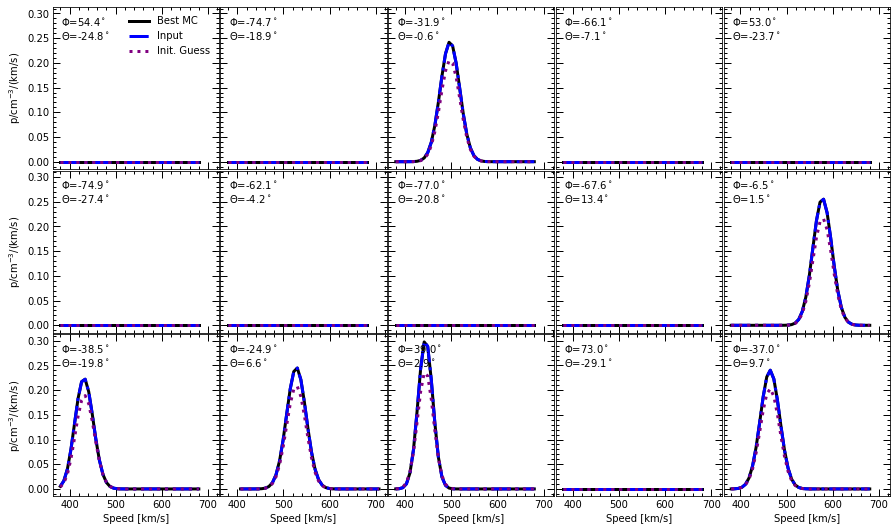

In [18]:
mff.create_fc_grid_plot(fcs)
plt.show()